In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import string


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


%matplotlib inline

# Read in the data from the CSV file and check the output.

In [4]:
#Read in CSV file
df = pd.read_csv('raw_data/PO_Dataset.csv')

#Print some records
df.head()


,Company #,Purchase Order,Item,Vendor,Description,Unit of Measure,Units,Unit Cost,Cost,Cost Code
0,8,1200-001,1,Paragon Electrical Installations Ltd.,Additional smoke detector/re-verification,LS,0,0.0,1444.0,26-20-20
1,8,1200-002,1,Accurate Aluminum Ltd,S&I railing as per quote Aug. 13 2015,LS,0,0.0,500.0,05-52-20
2,8,1200-003,1,Dura Productions,S&I metal ramp,LS,0,0.0,795.0,05-52-20
3,8,1200-004,1,Friesen Floors & Window Fashions Ltd,S&I hardwood flooring for enclosed balcony area,LS,0,0.0,2314.0,09-64-33
4,8,1209-1-01,1,Alba Painting Ltd.,Painting of two offices,LS,0,0.0,900.0,09-91-40


In [5]:
#Check how much data was loaded
print('File Contains Columns:{} Rows:{}'.format(df.shape[1], df.shape[0]))


File Contains Columns:10 Rows:39414


## Start cleaning the data

In [6]:
#What are the column types?
df.dtypes

Company #            int64
Purchase Order      object
Item                 int64
Vendor              object
Description         object
Unit of Measure     object
Units               object
Unit Cost          float64
Cost               float64
Cost Code           object
dtype: object

The Units column should be a float. It may be relevant to the prediction of cost type to know how many units of a product have been purchased.


In [7]:

#The Convert the Units column to float
df['Units'] = pd.to_numeric(df['Units'], errors='coerce').fillna(0)
df['Units'] = df['Units'].astype('float64')

#Confirm change
df.dtypes

Company #            int64
Purchase Order      object
Item                 int64
Vendor              object
Description         object
Unit of Measure     object
Units              float64
Unit Cost          float64
Cost               float64
Cost Code           object
dtype: object

In [8]:
#Do we have null values in any of the columns? 
print(df.isnull().sum())
df.dropna(inplace=True)

Company #           0
Purchase Order      0
Item                0
Vendor              2
Description        19
Unit of Measure     0
Units               0
Unit Cost           0
Cost                0
Cost Code           0
dtype: int64


There are some records that have null values in the Vendor or Description field. I'll leave them in the dataset because it's possible the cost code could be predicted from other features.

In [9]:
#How many unique cost codes do we see in the dataset?
print('{} unique cost codes in raw dataset'.format(df['Cost Code'].nunique()))

#Are all the cost codes formatted correctly and valid?
#Read in CSV file master list of cost codes
df_ml = pd.read_csv('raw_data/Code_Master_list.csv')
print('There are {} cost codes in the master list'.format(df_ml['Cost Code'].count()))

#Drop rows where the cost code is not in the master list
df = df[df['Cost Code'].isin(df_ml['Cost Code'])].dropna()


print('{} unique cost codes in dataset after cleaning'.format(df['Cost Code'].nunique()))
df['Cost Code'].unique()

375 unique cost codes in raw dataset
There are 905 cost codes in the master list
354 unique cost codes in dataset after cleaning


array(['26-20-20', '05-52-20', '09-64-33', '09-91-40', '09-21-17',
       '26-20-13', '26-60-10', '08-41-26', '08-11-13', '08-71-11',
       '10-21-13', '10-26-13', '10-28-14', '10-28-15', '08-83-13',
       '06-46-23', '01-52-19', '05-70-10', '06-10-80', '01-52-23',
       '03-80-11', '22-10-20', '01-58-13', '01-51-23', '21-10-14',
       '01-52-25', '01-74-13', '01-52-17', '08-43-26', '10-41-10',
       '09-30-60', '23-50-20', '05-50-10', '08-43-13', '07-32-10',
       '07-62-10', '07-71-23', '07-14-13', '08-63-10', '08-41-13',
       '02-41-13', '01-54-16', '06-10-63', '04-22-10', '32-31-13',
       '01-33-23', '03-80-10', '08-33-23', '07-81-10', '09-97-10',
       '03-35-10', '09-65-16', '26-80-10', '01-52-22', '10-14-70',
       '05-52-24', '06-22-10', '03-31-46', '05-10-10', '08-14-43',
       '01-52-16', '06-10-82', '08-34-80', '02-24-13', '28-10-13',
       '22-40-20', '31-45-21', '31-23-17', '31-11-10', '31-23-25',
       '31-22-13', '03-90-10', '01-56-26', '06-10-60', '06-10-

Let's use a heatmap to see what kind of correlation there is between some of the numeric data fields and the target cost code.

In [10]:
df_corr = df[['Vendor',
       'Unit of Measure', 'Units', 'Unit Cost', 'Cost', 'Cost Code']]

In [11]:
df_corr.dtypes

Vendor              object
Unit of Measure     object
Units              float64
Unit Cost          float64
Cost               float64
Cost Code           object
dtype: object

In [12]:
df_corr['Vendor Encoded'] = LabelEncoder().fit_transform(df_corr['Vendor'])
df_corr['Unit of Measure Encoded'] = LabelEncoder().fit_transform(df_corr['Unit of Measure'])
df_corr['Cost Code Encoded'] = LabelEncoder().fit_transform(df_corr['Cost Code'])

/Users/danielkelly/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/danielkelly/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [13]:
df_corr.drop(['Vendor','Unit of Measure','Cost Code'],axis=1,inplace=True)
df_corr.dtypes

/Users/danielkelly/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Units                      float64
Unit Cost                  float64
Cost                       float64
Vendor Encoded               int64
Unit of Measure Encoded      int64
Cost Code Encoded            int64
dtype: object

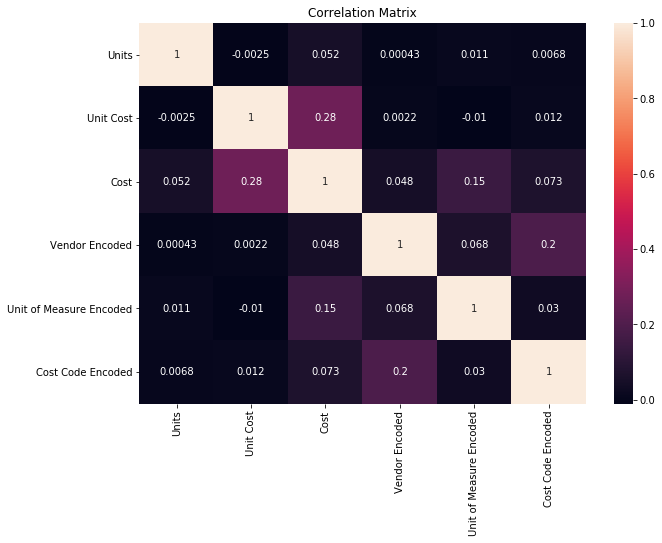

In [14]:
plt.figure(figsize = (10,7))
plt.title("Correlation Matrix")
sns.heatmap(df_corr.corr(),annot=True)

It looks like there is some correlation between the cost and vendor that relate to the cost code and smaller correlations with the other features.

## Analysis of Cost Code usage

From the cell above, we know that of 905 cost codes in the master list, only 354 have been used in this dataset.
This could mean two things. 
- We do not have a complete dataset and the accuracy of the model will suffer for this.
- Or the codes that are not represented by purchase orders are not relevant to the types of costs that are incurred by purchase orders. For example, cost code 00-10-11 - Architectural Consultant. An Architectural Consultant's services would be secured using a contract, not a purchase order. While the cost is still accrued to the job, it is not recorded through a purchase order therefore no purchase orders exist using this code.

Since the dataset is several years old and encompasses many projects and in addition to the reasoning explained in the example, I would lean towards the second point; that some cost codes are not relevant to purchase orders. So based on that decision, I will drop the unused codes from the output of the predictive model. This will decrease the number of output variables of the model from 905 to 354.

In [15]:
df_ml_clean = df_ml[df_ml['Cost Code'].isin(df['Cost Code'])].dropna()

print(df_ml_clean)
df_ml_clean.to_csv(r'clean_data/Clean_Code_Master_list.csv',index=False)

    Cost Code                            Description
7    00-10-17                geotechnical consultant
26   00-61-13                         subtrade bonds
34   01-30-12                        project manager
36   01-30-14                    project coordinator
45   01-30-23               finishing superintendent
52   01-30-30                                foreman
53   01-30-31                             flagperson
55   01-30-33                               labourer
56   01-30-40                         safety manager
57   01-30-41                                    cso
58   01-30-42                    first aid attendent
60   01-30-51                  deficiency technician
65   01-31-40                                cartage
66   01-32-33             photographic documentation
67   01-32-50                           bim modeling
68   01-33-23          submittal printing & drafting
69   01-45-41                scaffolding engineering
70   01-45-42                      crane engin

Average # of times a code is used: 111.03
Median # of times a code is used: 6.50
03-31-43 is the most used code used 5570 times


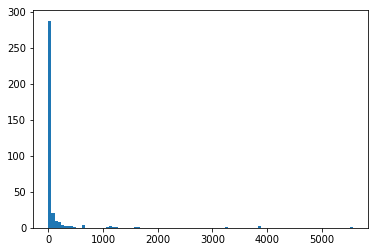

In [16]:
#How often are the codes used?

print("Average # of times a code is used: {:.2f}".format(df['Cost Code'].value_counts().mean()))
print("Median # of times a code is used: {:.2f}".format(df['Cost Code'].value_counts().median()))
print("{} is the most used code used {} times".format(df['Cost Code'].value_counts().idxmax(),df['Cost Code'].value_counts().max()))

plt.hist(df['Cost Code'].value_counts(), bins=100)
plt.show()

From this analysis we can see that the data is very unbalanced, with a small number of codes that have a very high usage, and most others with low usage. From this analysis we can tell that accuracy and recall would likely be poor metrics to evaluate the performance of the model, and precision or an F2-score weighted towards precision would be more valueable.

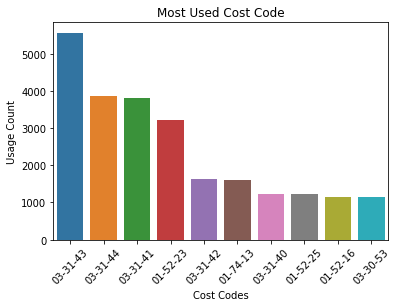

In [49]:
code_count = df['Cost Code'].value_counts().head(10)
sns.barplot(code_count.index, code_count.values)
plt.title('Most Used Cost Code')
plt.ylabel('Usage Count')
plt.xlabel('Cost Codes')
plt.xticks(rotation=45)
plt.show()

## Vendor use analysis

In [18]:
print('{} Vendors used'.format(df['Vendor'].nunique()))
print("Average # of times a Vendor is used: {:.2f}".format(df['Vendor'].value_counts().mean()))
print("Median # of times a Vendor is used: {:.2f}".format(df['Vendor'].value_counts().median()))
print("{} is the most used Vendor used {} times".format(df['Vendor'].value_counts().idxmax(),df['Vendor'].value_counts().max()))

598 Vendors used
Average # of times a Vendor is used: 65.72
Median # of times a Vendor is used: 4.00
Ocean Concrete is the most used Vendor used 9036 times


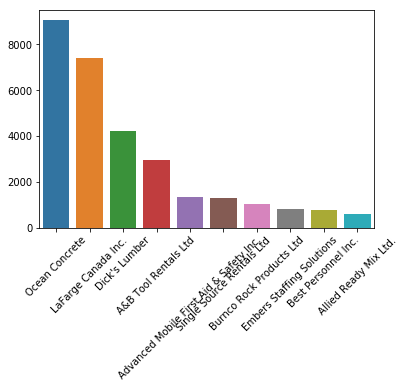

In [19]:
code_count = df['Vendor'].value_counts().head(10)
sns.barplot(code_count.index, code_count.values)
plt.xticks(rotation=45)
plt.show()

## Analysis of Numerical Fields
The Units, Unit Cost, and Cost fields are all numerical data related to the purchase order that intiutively may be related to the type of cost. I will start by exploring this data first.

In [20]:
#Describe the data, what kind of ranges are we dealing with for the relevant numerical fields?

df[['Units','Unit Cost','Cost']].describe()

,Units,Unit Cost,Cost
count,39303.000000,39303.000000,39303.000000
mean,27.093910,148.975775,1373.549263
std,641.505044,1897.340738,6928.548043
min,-30000.000000,-8483.230000,-22500.000000
25%,1.000000,2.035000,36.800000
50%,2.500000,9.470000,150.000000
75%,11.000000,63.000000,696.000000
max,102726.000000,300000.000000,639612.130000


From this description we see that there are negative values in each of the fields. These may be errors, but more likely they are credits back from the supplier where the company was overcharged for an item, and the supplier gave back some money.
In either case these records can be excluded from the dataset as they are not relevant to predicting the purchasing of new items.

In [21]:
#Update dataset to exclude rows with Units, Unit Cost, or Costs that are negative.
df = df[(df[['Units','Unit Cost','Cost']] >= 0).all(axis=1)]

df[['Units','Unit Cost','Cost']].describe()


,Units,Unit Cost,Cost
count,39141.000000,39141.000000,39141.000000
mean,27.998488,149.901813,1383.047704
std,624.646593,1900.609644,6939.240080
min,0.000000,0.000000,0.000000
25%,1.000000,2.150000,37.800000
50%,2.700000,9.800000,150.000000
75%,11.000000,64.000000,700.000000
max,102726.000000,300000.000000,639612.130000


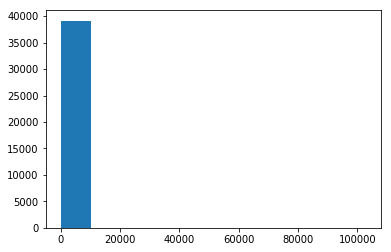

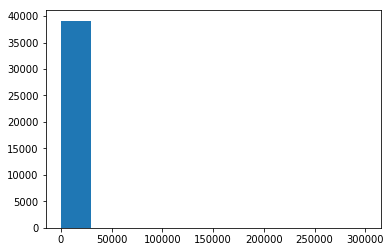

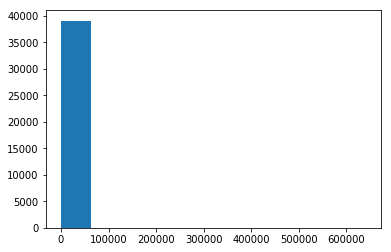

In [22]:
plt.hist(df['Units'], 10)
plt.show()
plt.hist(df['Unit Cost'], 10)
plt.show()
plt.hist(df['Cost'], 10)
plt.show()

Based on the percentiles and the histogram, we can clearly see that there are a very small number of high valued rows that are skewing the dataset highly. These are outliers that can be excluded from the data. So we will decrease the dataset to use only the 90th quartile for Costs, Units, and Unit Costs to get a more accurate representation of reality.

284460


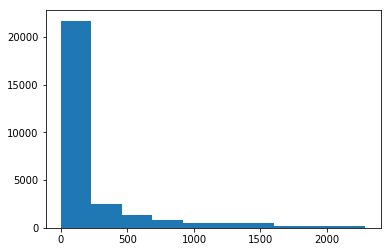

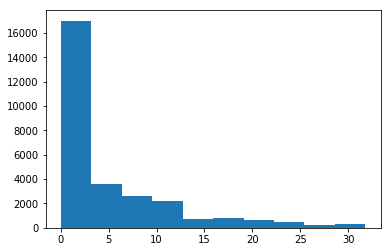

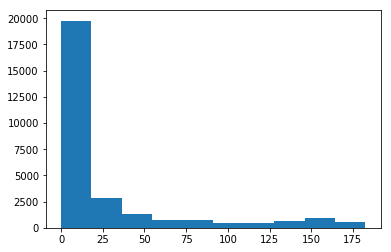

,Units,Unit Cost,Cost
count,28446.000000,28446.000000,28446.000000
mean,4.809546,26.707127,229.926338
std,6.528135,43.822091,388.835225
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,24.000000
50%,2.000000,8.000000,75.000000
75%,7.500000,25.500000,210.000000
max,31.800000,182.500000,2287.800000


In [23]:
#Create a new dataframe that takes only the 90th quartile of data from the 3 numerical columns.
df_90 = df[df['Cost'] < df['Cost'].quantile(.90)]
df_90 = df_90[df_90['Units'] < df_90['Units'].quantile(.90)]
df_90 = df_90[df_90['Unit Cost'] < df_90['Unit Cost'].quantile(.90)]


print(df_90.size)


plt.hist(df_90['Cost'], 10)
plt.show()

plt.hist(df_90['Units'], 10)
plt.show()

plt.hist(df_90['Unit Cost'], 10)
plt.show()

df_90[['Units','Unit Cost','Cost']].describe()

Average # of times a code is used: 242.57
Median # of times a code is used: 45.00
03-31-43 is the most used code used 4157 times


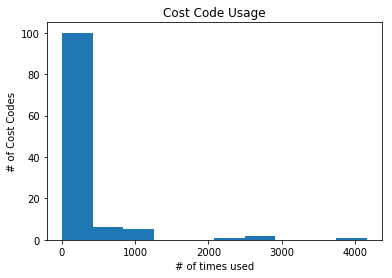

In [50]:
#looking at the cost code usage statistics again after cleaning up the records.

print("Average # of times a code is used: {:.2f}".format(df_90['Cost Code'].value_counts().mean()))
print("Median # of times a code is used: {:.2f}".format(df_90['Cost Code'].value_counts().median()))
print("{} is the most used code used {} times".format(df_90['Cost Code'].value_counts().idxmax(),df_90['Cost Code'].value_counts().max()))

plt.hist(df_90['Cost Code'].value_counts(), bins=10)
plt.title('Cost Code Usage')
plt.xlabel('# of times used')
plt.ylabel('# of Cost Codes')
plt.show()

In [25]:
# It's a good practice to scale numerical data
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() 
numerical = ['Units','Unit Cost','Cost']

df_90[numerical] = scaler.fit_transform(df_90[numerical])

# Show an example of a record with scaling applied
display(df_90.head(10))

,Company #,Purchase Order,Item,Vendor,Description,Unit of Measure,Units,Unit Cost,Cost,Cost Code
0,8,1200-001,1,Paragon Electrical Installations Ltd.,Additional smoke detector/re-verification,LS,0.000000,0.000000,0.631174,26-20-20
1,8,1200-002,1,Accurate Aluminum Ltd,S&I railing as per quote Aug. 13 2015,LS,0.000000,0.000000,0.218551,05-52-20
2,8,1200-003,1,Dura Productions,S&I metal ramp,LS,0.000000,0.000000,0.347495,05-52-20
4,8,1209-1-01,1,Alba Painting Ltd.,Painting of two offices,LS,0.000000,0.000000,0.393391,09-91-40
9,8,1209-1-04,2,Renner Glass Inc.,S&I door lock,LS,0.000000,0.000000,0.050267,08-41-26
11,8,1209-1-05,1,Robertson Walls & Ceilings,Demolition - wall/carpeting/platform,LS,0.000000,0.000000,0.328700,09-21-17
14,8,1212-002,1,Shanahan's,Hollow metal frames,EA,0.062893,0.876712,0.139872,08-11-13
17,8,1212-002,4,Shanahan's,Corner Guards,EA,0.251572,0.458192,0.292403,10-26-13
23,8,1212-002,10,Shanahan's,Finish Hardware,LS,0.000000,0.000000,0.330011,08-71-11
24,8,1212-002,11,Shanahan's,Grab Bars,LS,0.000000,0.000000,0.032682,10-28-15


In [26]:
# When splitting for training and testing later, we'll need a minimum of 2 examples of each cost code.
# Assign cost code to a variable
df_count = df_90['Cost Code'].value_counts()

#New dataframe only includes lines with cost codes with a count of 10 or greater
df_90 = df_90[~df_90['Cost Code'].isin(df_count[df_count < 10].index)]

## Text Data Exploration

In [27]:
#Separate out the description into a new Dataframe so we can analyse it.
df_desc = df_90.filter(['Description'])
df_desc.reset_index(inplace=True)
df_desc.head(5)

,index,Description
0,1,S&I railing as per quote Aug. 13 2015
1,2,S&I metal ramp
2,4,Painting of two offices
3,14,Hollow metal frames
4,23,Finish Hardware


In [28]:
#Remove Punctuation and create new column text
df_desc['text'] = df['Description'].str.replace('[^\w\s]','')

In [29]:
from nltk.tokenize import word_tokenize

#What are the most common words used in the description?

words = word_tokenize(df_desc['text'].str.lower().str.cat(sep= ' '))
words_dist = nltk.FreqDist(words)
result = pd.DataFrame(words_dist.most_common(20),columns=['Word','Frequecy'])
print(result)

             Word  Frequecy
0              to      4805
1        concrete      4174
2             per      3529
3             all      3210
4            fuel      2670
5         applies      2564
6          charge      2445
7              m3      2281
8   environmental      2276
9       surcharge      2047
10           load      1729
11            and      1514
12              1      1467
13             14      1112
14           levy       996
15            mar       826
16        invoice       818
17           14mm       816
18          slump       776
19         carbon       716


In [30]:
#split the description into words and analyse
df_desc['# words'] = df_desc['Description'].apply(lambda x: len(x.split()))
print('Average # of words per description {:.2f} \nLongest description {} words'.format(df_desc['# words'].mean(),df_desc['# words'].max()))

Average # of words per description 4.31 
Longest description 15 words


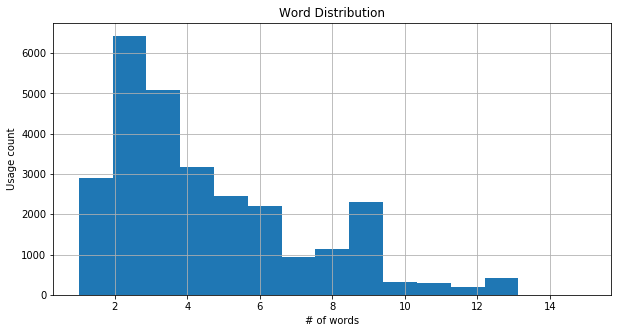

In [51]:
#What does the distribution of # of words per description look like?

df_desc['# words'].hist( bins = 15, figsize=(10,5))
plt.title('Word Distribution')
plt.xlabel('# of words')
plt.ylabel('Usage count')
plt.show()

## Encoding Categorical variables
    The variables Vendor, Cost Code, and Unit of Measure are Categorical and need to be converted for use in the model. I will use One-Hot-Encoding because this data is nominal, not Ordinal. This makes it unsuitable for label encoding. One Hot Encoding will increase the dimensionality of the data significantly, as there are over 600 vendors and 350 Cost Codes. We may be able to use PCA (Principal Component analysis to reduce the number of dimensions without much affect the accuracy.

In [32]:
#Split the data into features and target variable


categorical = ['Vendor', 'Unit of Measure']
df_90 = pd.get_dummies(df_90, columns = categorical )



In [33]:
df_90

,Company #,Purchase Order,Item,Description,Units,Unit Cost,Cost,Cost Code,Vendor_1110438 B.C. Ltd,Vendor_4s Scaffolding,...,Unit of Measure_kg,Unit of Measure_km,Unit of Measure_kw,Unit of Measure_l,Unit of Measure_m,Unit of Measure_m2,Unit of Measure_m3,Unit of Measure_m3,Unit of Measure_mL,Unit of Measure_t
1,8,1200-002,1,S&I railing as per quote Aug. 13 2015,0.000000,0.000000,0.218551,05-52-20,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,1200-003,1,S&I metal ramp,0.000000,0.000000,0.347495,05-52-20,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,1209-1-01,1,Painting of two offices,0.000000,0.000000,0.393391,09-91-40,0,0,...,0,0,0,0,0,0,0,0,0,0
14,8,1212-002,1,Hollow metal frames,0.062893,0.876712,0.139872,08-11-13,0,0,...,0,0,0,0,0,0,0,0,0,0
23,8,1212-002,10,Finish Hardware,0.000000,0.000000,0.330011,08-71-11,0,0,...,0,0,0,0,0,0,0,0,0,0
29,8,1212-007,1,Portable Toilet rental; weekly cleaning May 31,0.000000,0.000000,0.010761,01-52-19,0,0,...,0,0,0,0,0,0,0,0,0,0
30,8,1212-007,2,Weekly cleaning - May 16,0.000000,0.000000,0.038841,01-52-19,0,0,...,0,0,0,0,0,0,0,0,0,0
31,8,1212-007,3,Cleaning June 2 5 12 19 26,0.000000,0.000000,0.054288,01-52-19,0,0,...,0,0,0,0,0,0,0,0,0,0
32,8,1212-007,4,Final billing/removal,0.000000,0.000000,0.019739,01-52-19,0,0,...,0,0,0,0,0,0,0,0,0,0
34,8,1212-009,1,Lumber for back framing,0.000000,0.000000,0.105595,06-10-80,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#cost_code_encoded = pd.get_dummies(cost_code)
cost_code = df_90['Cost Code']
df_90['Cost Code Encoded'] = LabelEncoder().fit_transform(cost_code)


display(df_90['Cost Code'].unique())
display(df_90['Cost Code Encoded'].unique())

array(['05-52-20', '09-91-40', '08-11-13', '08-71-11', '01-52-19',
       '06-10-80', '01-52-23', '03-80-11', '01-58-13', '01-51-23',
       '01-52-25', '01-74-13', '01-52-17', '10-41-10', '05-50-10',
       '07-62-10', '01-54-16', '01-33-23', '03-80-10', '26-80-10',
       '01-52-22', '10-14-70', '03-31-46', '01-52-16', '06-10-82',
       '06-22-10', '31-23-25', '31-23-17', '03-90-10', '01-56-26',
       '06-10-60', '02-41-30', '31-81-24', '10-31-10', '31-22-20',
       '06-10-81', '07-84-10', '01-31-40', '09-21-16', '01-76-20',
       '01-30-42', '03-36-10', '01-54-23', '01-57-30', '03-30-53',
       '01-57-40', '01-51-26', '08-71-10', '22-40-15', '07-92-10',
       '02-41-20', '10-28-16', '01-51-36', '09-91-23', '31-25-12',
       '01-71-23', '01-52-13', '01-30-31', '01-30-30', '01-54-19',
       '01-56-30', '01-51-13', '31-23-23', '01-52-21', '01-57-20',
       '01-56-29', '31-81-21', '01-57-41', '09-64-70', '01-56-40',
       '01-30-33', '31-25-11', '01-54-24', '31-23-19', '01-30-

array([ 69,  89,  83,  85,  16,  72,  20,  66,  40,   9,  22,  42,  15,
        93,  68,  80,  24,   7,  65,  99,  19,  90,  60,  14,  74,  76,
       106, 102,  67,  31,  71,  46, 112,  92, 101,  73,  81,   6,  86,
        43,   4,  61,  26,  37,  52,  38,  10,  84,  95,  82,  45,  91,
        12,  88, 108,  41,  13,   1,   0,  25,  33,   8, 104,  18,  36,
        32, 111,  39,  87,  35,   2, 107,  27, 103,   3,  49,  17,  29,
        53, 110,  21, 100,  56,  98,  59,  28,  23,   5,  47,  62,  51,
        58,  55,  54,  57,  50,  64, 109,  97, 113,  44,  78, 114,  11,
        30,  34,  79,  77,  75,  63,  70,  94,  96, 105,  48])

In [35]:
#drop features I won't be using
df_90 = df_90.drop(['Company #','Purchase Order', 'Item'], axis = 1)

In [36]:
df_90.head()

,Description,Units,Unit Cost,Cost,Cost Code,Vendor_1110438 B.C. Ltd,Vendor_4s Scaffolding,Vendor_596143 BC LTD DBA AVANTE 2000,Vendor_7 Star Security Services Inc,Vendor_A & A Testing Ltd.,...,Unit of Measure_km,Unit of Measure_kw,Unit of Measure_l,Unit of Measure_m,Unit of Measure_m2,Unit of Measure_m3,Unit of Measure_m3,Unit of Measure_mL,Unit of Measure_t,Cost Code Encoded
1,S&I railing as per quote Aug. 13 2015,0.000000,0.000000,0.218551,05-52-20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,69
2,S&I metal ramp,0.000000,0.000000,0.347495,05-52-20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,69
4,Painting of two offices,0.000000,0.000000,0.393391,09-91-40,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,89
14,Hollow metal frames,0.062893,0.876712,0.139872,08-11-13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,83
23,Finish Hardware,0.000000,0.000000,0.330011,08-71-11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,85


## Write to file

In [37]:
#Write the dataframe to a CSV file
#df_90.to_csv(r'clean_data/clean_data.csv', index=False)
#features_encoded.to_csv(r'clean_data/features_encoded.csv', index=False)
#cost_code_encoded.to_csv(r'clean_data/cost_code_encoded.csv', index=False)

## Benchmark Model

In [38]:

#True positive - if the model always picks the most used cost code
TP = df_90['Cost Code'].value_counts().max()

# True negative is 0 since we never predict a negative
TN = 0

# False positive = total predictions - true positives
FP = int((df_90['Cost Code'].size)) - TP

# False negative is 0 since we never predict a negative
FN = 0

accuracy = (TP + TN) / (TP + FP + FN + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1score = 2 * (precision * recall)/(precision + recall)
beta = 0.5
fbeta = (1+beta**2) * ((precision*recall)/((beta**2 * precision) + recall))
print('Benchmark model Accuracy: {:.2f}  Precision: {:.2f}  Recall: {:.2f}  f1-score: {:.2f}  fbeta-score: {:.2f}'.format(accuracy, precision, recall, f1score, fbeta))




Benchmark model Accuracy: 0.15  Precision: 0.15  Recall: 1.00  f1-score: 0.26  fbeta-score: 0.18
